In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader  
from skimage import io

In [4]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Soft Computing/Assignment 2/Dataset C.zip"

Streaming output truncated to the last 5000 lines.
  inflating: training-c/c19300.png   
  inflating: training-c/c19301.png   
  inflating: training-c/c19302.png   
  inflating: training-c/c19303.png   
  inflating: training-c/c19304.png   
  inflating: training-c/c19305.png   
  inflating: training-c/c19306.png   
  inflating: training-c/c19307.png   
  inflating: training-c/c19308.png   
  inflating: training-c/c19309.png   
  inflating: training-c/c19310.png   
  inflating: training-c/c19311.png   
  inflating: training-c/c19312.png   
  inflating: training-c/c19313.png   
  inflating: training-c/c19314.png   
  inflating: training-c/c19315.png   
  inflating: training-c/c19316.png   
  inflating: training-c/c19317.png   
  inflating: training-c/c19318.png   
  inflating: training-c/c19319.png   
  inflating: training-c/c19320.png   
  inflating: training-c/c19321.png   
  inflating: training-c/c19322.png   
  inflating: training-c/c19323.png   
  inflating: training-c/c19324.png   

# Loading Dataset

In [5]:
# reading Dataset
data = pd.read_csv('training-c.csv')
data.head(1)

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,c00000.png,Scan_280_digit_6_num_7.png,280,6,OngkoDB,Buet_Backpropers,training-c


In [6]:
# dropping columns
data.drop(['original filename','scanid'],axis=1,inplace=True)
data.drop(data.columns[2:5],axis=1,inplace=True)
data.head(1)

,filename,digit
0,c00000.png,6


In [7]:
class Digit_dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 3]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [8]:
import torchvision.transforms as transforms
data = Digit_dataset("/content/training-c.csv","/content/training-c", transforms.Compose([transforms.ToPILImage(), transforms.Resize(size=(28, 28)), transforms.ToTensor()]))

In [9]:
data.__len__()


24298

In [10]:
train_dataset, test_dataset = torch.utils.data.random_split(data, [19438, 4860])

In [11]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# Experiment 2_01

In [ ]:
# Hyperparameters

batch_size = 40
num_iters = 60000
input_dim = 28*28 # num_features = 784
num_hidden = 1000 # num of hidden nodes
output_dim = 10

learning_rate = 0.1  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_4 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_3(out)
        
        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_4(out)
     
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
  

Iteration: 500. Loss: 2.3023715019226074. Accuracy: 9.814814814814815
Iteration: 1000. Loss: 2.281980514526367. Accuracy: 10.37037037037037
Iteration: 1500. Loss: 2.3016610145568848. Accuracy: 14.156378600823045
Iteration: 2000. Loss: 2.2813732624053955. Accuracy: 16.152263374485596
Iteration: 2500. Loss: 2.266397714614868. Accuracy: 10.637860082304528
Iteration: 3000. Loss: 2.280111312866211. Accuracy: 10.473251028806585
Iteration: 3500. Loss: 2.250925064086914. Accuracy: 10.2880658436214
Iteration: 4000. Loss: 2.300588607788086. Accuracy: 10.349794238683128
Iteration: 4500. Loss: 2.312934398651123. Accuracy: 14.053497942386832
Iteration: 5000. Loss: 2.2809596061706543. Accuracy: 14.465020576131687
Iteration: 5500. Loss: 2.26591157913208. Accuracy: 10.699588477366255
Iteration: 6000. Loss: 2.163665771484375. Accuracy: 19.444444444444443
Iteration: 6500. Loss: 2.2621495723724365. Accuracy: 9.876543209876543
Iteration: 7000. Loss: 2.2707645893096924. Accuracy: 13.004115226337449
Iterati

[2.3023715019226074, 2.281980514526367, 2.3016610145568848, 2.2813732624053955, 2.266397714614868, 2.280111312866211, 2.250925064086914, 2.300588607788086, 2.312934398651123, 2.2809596061706543, 2.26591157913208, 2.163665771484375, 2.2621495723724365, 2.2707645893096924, 2.2505316734313965, 2.0418944358825684, 2.2410871982574463, 2.083998203277588, 2.1366124153137207, 2.1820099353790283, 2.132401943206787, 2.102086067199707, 2.2655038833618164, 2.2238833904266357, 2.1237592697143555, 2.1365303993225098, 2.075192928314209, 2.3169591426849365, 1.9807510375976562, 2.329127788543701, 2.0372164249420166, 2.216348171234131, 1.9067051410675049, 1.9984267950057983, 2.169142007827759, 2.0034632682800293, 2.0624794960021973, 2.0662131309509277, 2.2675156593322754, 2.0087010860443115, 1.9351857900619507, 2.109276294708252, 2.097191333770752, 1.7449090480804443, 1.8598318099975586, 1.9847503900527954, 1.9119818210601807, 1.7626453638076782, 1.986562967300415, 1.880393385887146, 2.4125030040740967,

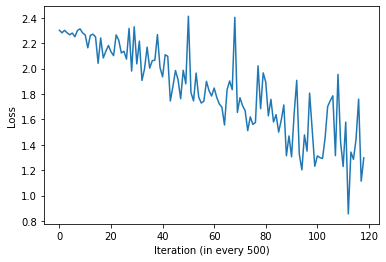

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# Experiment 2_02

In [ ]:
# Hyperparameters

batch_size = 60
num_iters = 90000
input_dim = 28*28 # num_features = 784
num_hidden = 2000 # num of hidden nodes
output_dim = 10

learning_rate = 0.1  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_4 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_3(out)
        
        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_4(out)
     
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2966413497924805. Accuracy: 10.020576131687243
Iteration: 1000. Loss: 2.3074610233306885. Accuracy: 12.469135802469136
Iteration: 1500. Loss: 2.294485330581665. Accuracy: 10.061728395061728
Iteration: 2000. Loss: 2.226813793182373. Accuracy: 10.041152263374485
Iteration: 2500. Loss: 2.2167563438415527. Accuracy: 19.526748971193417
Iteration: 3000. Loss: 2.297435760498047. Accuracy: 18.930041152263374
Iteration: 3500. Loss: 2.217493772506714. Accuracy: 21.255144032921812
Iteration: 4000. Loss: 2.243117332458496. Accuracy: 13.991769547325102
Iteration: 4500. Loss: 2.2716434001922607. Accuracy: 25.0
Iteration: 5000. Loss: 2.2306900024414062. Accuracy: 14.40329218106996
Iteration: 5500. Loss: 2.234102725982666. Accuracy: 14.526748971193415
Iteration: 6000. Loss: 2.208698272705078. Accuracy: 14.156378600823045
Iteration: 6500. Loss: 2.122713565826416. Accuracy: 23.045267489711936
Iteration: 7000. Loss: 2.206122875213623. Accuracy: 16.74897119341564
Iteration: 7500. L

[2.2966413497924805, 2.3074610233306885, 2.294485330581665, 2.226813793182373, 2.2167563438415527, 2.297435760498047, 2.217493772506714, 2.243117332458496, 2.2716434001922607, 2.2306900024414062, 2.234102725982666, 2.208698272705078, 2.122713565826416, 2.206122875213623, 2.198669195175171, 2.1213185787200928, 2.20878267288208, 2.288980007171631, 2.155330181121826, 2.13600754737854, 2.2146856784820557, 2.3074166774749756, 1.9454394578933716, 2.0545592308044434, 2.0950984954833984, 2.217082977294922, 2.1413626670837402, 1.992679238319397, 2.2094130516052246, 2.174017906188965, 1.8836514949798584, 1.9980508089065552, 1.9646049737930298, 1.9898600578308105, 2.0102956295013428, 1.9579066038131714, 1.8689630031585693, 1.9844390153884888, 1.8952161073684692, 1.8764697313308716, 2.0806074142456055, 1.792921543121338, 2.124553918838501, 1.8309129476547241, 1.9571094512939453, 1.853455662727356, 2.084347724914551, 1.734846591949463, 1.7802655696868896, 1.848885416984558, 1.8982115983963013, 1.75

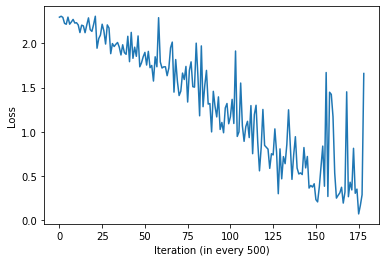

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# Save Model

In [ ]:
save_model = True
root_path= '/content/drive/MyDrive/Colab Notebooks'
if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), 'exp2.pkl') 

In [ ]:
# Load Model
load_model = True

if load_model is True:
    model.load_state_dict(torch.load('exp2.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


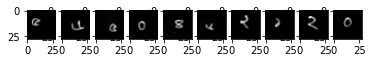

In [ ]:
# Testing Loaded Model
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [ ]:
predictions = model.forward(images[:10].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [9 6 0 0 4 9 2 2 2 0]


# Experiment 2_03

In [70]:
# Hyperparameters

batch_size = 128
num_iters = 80000
input_dim = 28*28 # num_features = 784
num_hidden = 400 # num of hidden nodes
output_dim = 10

learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [71]:
'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

In [72]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_3(out)
     
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.303990125656128. Accuracy: 11.522633744855968
Iteration: 1000. Loss: 2.3028059005737305. Accuracy: 12.098765432098766
Iteration: 1500. Loss: 2.3030858039855957. Accuracy: 13.106995884773662
Iteration: 2000. Loss: 2.2996487617492676. Accuracy: 12.592592592592593
Iteration: 2500. Loss: 2.300548791885376. Accuracy: 15.925925925925926
Iteration: 3000. Loss: 2.29984712600708. Accuracy: 12.469135802469136
Iteration: 3500. Loss: 2.2977540493011475. Accuracy: 9.300411522633745
Iteration: 4000. Loss: 2.2989189624786377. Accuracy: 9.279835390946502
Iteration: 4500. Loss: 2.2986695766448975. Accuracy: 10.781893004115226
Iteration: 5000. Loss: 2.296708345413208. Accuracy: 12.798353909465021
Iteration: 5500. Loss: 2.2981648445129395. Accuracy: 22.962962962962962
Iteration: 6000. Loss: 2.2925095558166504. Accuracy: 19.48559670781893
Iteration: 6500. Loss: 2.2883095741271973. Accuracy: 19.444444444444443
Iteration: 7000. Loss: 2.284133195877075. Accuracy: 20.37037037037037
Ite

[2.303990125656128, 2.3028059005737305, 2.3030858039855957, 2.2996487617492676, 2.300548791885376, 2.29984712600708, 2.2977540493011475, 2.2989189624786377, 2.2986695766448975, 2.296708345413208, 2.2981648445129395, 2.2925095558166504, 2.2883095741271973, 2.284133195877075, 2.2613468170166016, 2.2594430446624756, 2.18894624710083, 2.3130698204040527, 2.2063794136047363, 2.2152013778686523, 2.16398286819458, 2.1586005687713623, 2.230443000793457, 2.1519927978515625, 2.2730154991149902, 2.2182464599609375, 2.1659035682678223, 2.102745294570923, 2.0874290466308594, 2.008704662322998, 1.994975209236145, 2.0929312705993652, 2.1490659713745117, 2.0385687351226807, 1.9833406209945679, 2.164391040802002, 2.0547420978546143, 2.062518358230591, 1.8288918733596802, 1.9206328392028809, 1.9535166025161743, 2.0543980598449707, 1.8589495420455933, 1.9361791610717773, 1.8500438928604126, 1.9232757091522217, 1.9683117866516113, 1.7797651290893555, 1.921720027923584, 1.8538178205490112, 2.19354391098022

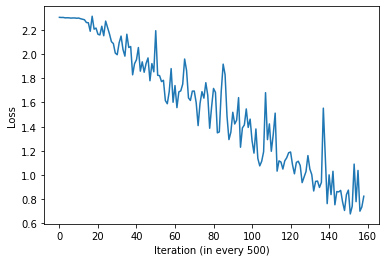

In [73]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# Save Model

In [74]:
save_model = True
root_path= '/content/drive/MyDrive/Colab Notebooks'
if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), 'exp2_temp.pkl') 

In [75]:
# Load Model
load_model = True

if load_model is True:
    model.load_state_dict(torch.load('exp2_temp.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


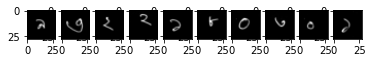

In [79]:
# Testing Loaded Model
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [80]:
predictions = model.forward(images[:10].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [1 6 2 7 1 8 0 3 0 1]


# Experiment 2_04

In [ ]:
# Hyperparameters

batch_size = 100
num_iters = 80000
input_dim = 28*28 # num_features = 784
num_hidden = 600 # num of hidden nodes
output_dim = 10

learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_4 = nn.ReLU()
        
        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_4(out)
     
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3037056922912598. Accuracy: 9.979423868312757
Iteration: 1000. Loss: 2.301532745361328. Accuracy: 9.62962962962963
Iteration: 1500. Loss: 2.300656795501709. Accuracy: 9.794238683127572
Iteration: 2000. Loss: 2.3025362491607666. Accuracy: 9.62962962962963
Iteration: 2500. Loss: 2.301924467086792. Accuracy: 13.683127572016462
Iteration: 3000. Loss: 2.301124334335327. Accuracy: 9.320987654320987
Iteration: 3500. Loss: 2.301311492919922. Accuracy: 17.94238683127572
Iteration: 4000. Loss: 2.3008921146392822. Accuracy: 9.691358024691358
Iteration: 4500. Loss: 2.3005290031433105. Accuracy: 11.090534979423868
Iteration: 5000. Loss: 2.3018031120300293. Accuracy: 12.489711934156379
Iteration: 5500. Loss: 2.30061936378479. Accuracy: 10.061728395061728
Iteration: 6000. Loss: 2.2980966567993164. Accuracy: 12.757201646090534
Iteration: 6500. Loss: 2.2980897426605225. Accuracy: 16.02880658436214
Iteration: 7000. Loss: 2.298949718475342. Accuracy: 15.534979423868313
Iteration: 

[2.3037056922912598, 2.301532745361328, 2.300656795501709, 2.3025362491607666, 2.301924467086792, 2.301124334335327, 2.301311492919922, 2.3008921146392822, 2.3005290031433105, 2.3018031120300293, 2.30061936378479, 2.2980966567993164, 2.2980897426605225, 2.298949718475342, 2.300384283065796, 2.297464609146118, 2.296590566635132, 2.2968811988830566, 2.2908573150634766, 2.288531541824341, 2.274722099304199, 2.2550034523010254, 2.2466840744018555, 2.247620105743408, 2.2524948120117188, 2.2344720363616943, 2.1686484813690186, 2.1734089851379395, 2.155113935470581, 2.1428496837615967, 2.2654218673706055, 2.4493539333343506, 2.014796733856201, 2.199434280395508, 2.103997230529785, 2.1478216648101807, 2.230799913406372, 2.0404062271118164, 2.0119965076446533, 2.10990834236145, 2.0778884887695312, 2.2631125450134277, 1.9079574346542358, 2.0573718547821045, 1.9761073589324951, 2.015162467956543, 2.063105821609497, 2.240926742553711, 1.8562018871307373, 2.0230660438537598, 1.8688344955444336, 1.8

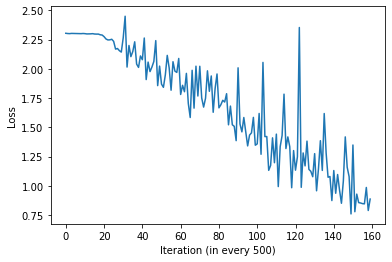

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
save_model = True
root_path= '/content/drive/MyDrive/Colab Notebooks'
if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), 'exp2_temp1.pkl') 

In [ ]:
# Load Model
load_model = True

if load_model is True:
    model.load_state_dict(torch.load('exp2_temp.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


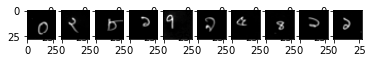

In [ ]:
# Testing Loaded Model
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [ ]:
predictions = model.forward(images[:10].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [0 2 0 1 7 9 9 4 1 2]
